In [1]:
import time
import pickle
import cupy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from NN_Regressor import NeuralNetworkRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
data = fetch_california_housing()
X = data.data
y = data.target.reshape(-1, 1)

In [3]:
df = pd.DataFrame(
    data=data.data,
    columns=data.feature_names
)
df['target'] = data.target
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [4]:
df.isna().sum().sum()

0

In [5]:
z_scores = (df - df.mean()) / df.std()

threshold = 3
df_clean = df[(z_scores.abs() <= threshold).all(axis=1)]

print("Data shape before outlier removal:", df.shape)
print("Data shape after outlier removal:", df_clean.shape)

X = df_clean.drop('target', axis=1).values
y = df_clean['target'].values.reshape(-1, 1)

Data shape before outlier removal: (20640, 9)
Data shape after outlier removal: (19794, 9)


In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

In [8]:
X_train.shape

(15835, 8)

In [9]:
n_input = X_train.shape[1]
n_output = 1
layer_dims = [n_input, 128, 64, 32, 16, n_output]
activations = ['leaky_relu', 'leaky_relu', 'leaky_relu', 'leaky_relu', 'linear']

In [10]:
nn = NeuralNetworkRegressor(
    layer_dims=layer_dims,
    activations=activations,
    epoch=100,
    batch_size=32,
    learning_rate=0.0005,
    decay_rate=0.98,
    verbose=1
)

In [11]:
start_time = time.time()
nn.fit(cp.asarray(X_train), cp.asarray(y_train))
training_time = time.time() - start_time
print(f"\nTraining completed in {training_time:.2f} seconds.")

Using GPU
GPU Device Name: NVIDIA GeForce RTX 4060 Laptop GPU
                                                                                                    
Training completed in 139.95 seconds.


In [12]:
y_pred = nn.predict(X_test)
y_pred_cpu = cp.asnumpy(y_pred)

In [13]:
mse = mean_squared_error(y_test, y_pred_cpu)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_cpu)

In [14]:
print("\nTest set performance:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


Test set performance:
Mean Squared Error (MSE): 0.3159
Root Mean Squared Error (RMSE): 0.5621
R² Score: 0.7437


In [15]:
y_pred_train = nn.predict(X_train)
y_pred_numpy = cp.asarray(y_pred_train)
r2 = r2_score(y_train, y_pred_numpy.get())
print(f"R² Score: {r2:.4f}")

R² Score: 0.7919


In [16]:
with open("cal_housing_model.pkl", "wb") as f:
    pickle.dump(nn, f)

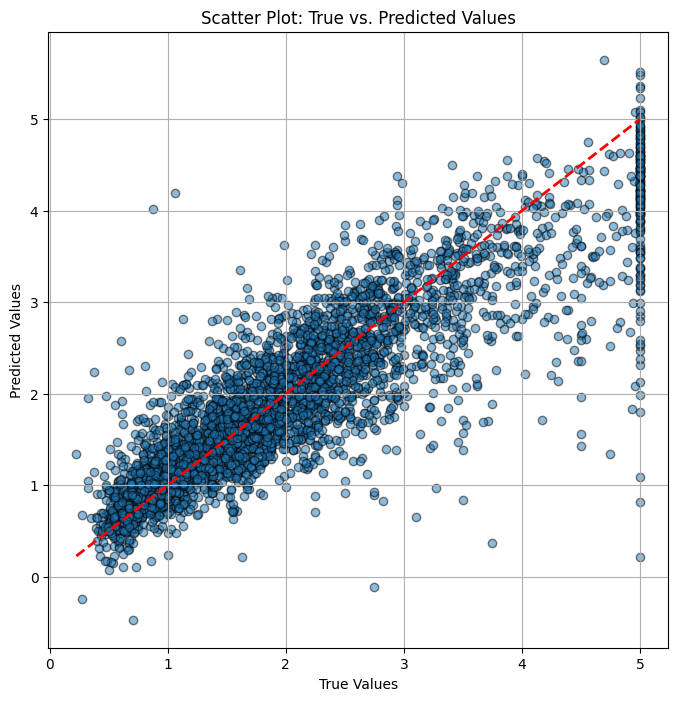

In [17]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_cpu, alpha=0.5, edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Scatter Plot: True vs. Predicted Values")
plt.grid(True)
plt.show()

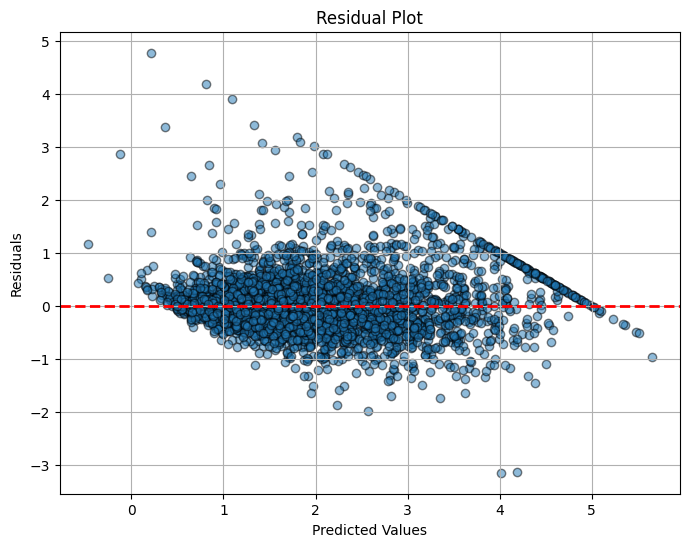

In [18]:
residuals = y_test - y_pred_cpu
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_cpu, residuals, alpha=0.5, edgecolor='k')
plt.axhline(0, color='red', linestyle='--', lw=2)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.grid(True)
plt.show()

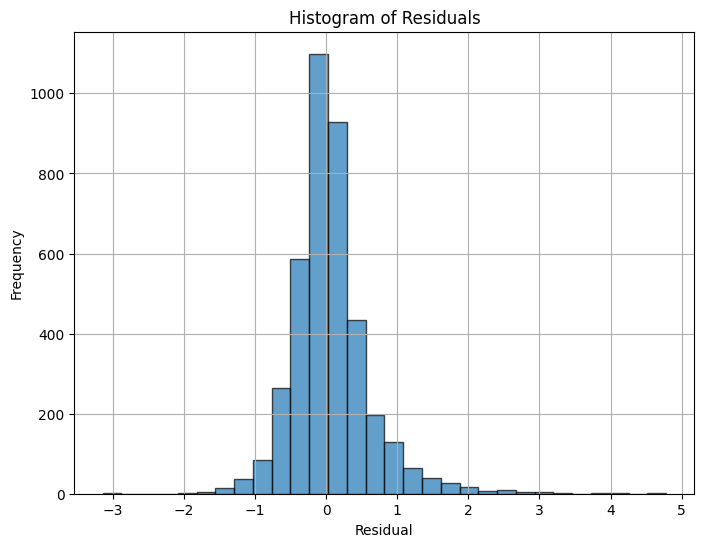

In [19]:
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.grid(True)
plt.show()

# Performance

### No outliers removed + No handling for exploding gradients

```Test set performance:
Mean Squared Error (MSE): 0.3101
Root Mean Squared Error (RMSE): 0.5569
R² Score: 0.7634
```

### Outliers removed using IQR + No handling for exploding gradients
```Test set performance:
Mean Squared Error (MSE): 0.2455
Root Mean Squared Error (RMSE): 0.4954
R² Score: 0.7192
```

### Outliers removed using IQR + Used gradient clipping at max_norm = 1.0
```
Test set performance:
Mean Squared Error (MSE): 0.2948
Root Mean Squared Error (RMSE): 0.5429
R² Score: 0.6628
```

### Outliers removed using Z-score + Used gradient clipping at max_norm = 7.0
```
Test set performance:
Mean Squared Error (MSE): 0.3279
Root Mean Squared Error (RMSE): 0.5727
R² Score: 0.7340
```

### Outliers removed using Z-score + Used gradient clipping at max_norm = 7.0 and used leaky_relu instead of relu
```
Test set performance:
Mean Squared Error (MSE): 0.3277
Root Mean Squared Error (RMSE): 0.5725
R² Score: 0.7341
```